In [1]:
import sys
import glob
import os
import re
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.ticker as mtick
%matplotlib inline

In [206]:
def uses(parts):
    remove = ["--use-cls", "--use-index"]
    uses_cls = "--use-cls" in parts
    uses_idx = "--use-index" in parts
    parts = filter(lambda v: v not in remove, parts)
    return uses_cls, uses_idx, parts

def get_sel(ep):
    if ep == 91400.0:
        return 1.0
    elif ep == 71000.0:
        return 10.0
    elif ep == 1.0:
        return 100.0
    assert False
    
def get_sel2(c):
    if c == "ave":
        return 1.0
    elif c == "uriously":
        return 10.0
    elif c[0] == "[":
        return 100.0
    assert False

def process_line(line):
    ignore = ["run-query", "--quiet", "run-1", "run-2"]
    if line[:9] != "run-query":
        return None
    parts = line.split()
    parts = filter(lambda v: v not in ignore, parts)
    # runtime
    runtime = float(parts[-1])
    parts = parts[:-1]
    # use cls
    uses_cls, uses_idx, parts = uses(parts)
    # convert to key/value pairs
    assert len(parts) % 2 == 0
    res = {'runtime': runtime, 'cls': uses_cls, 'idx': uses_idx}
    pit = iter(parts)
    for key in pit:
        assert key[:2] == "--"
        key = key[2:]
        val = next(pit)
        try:
            val = float(val)
        except:
            pass
        res.update({key:val})
    if 'extended-price' in res:
        res.update({'sel': get_sel(res["extended-price"])})
    elif 'comment_regex' in res:
        res.update({'sel': get_sel2(res["comment_regex"])})
    else:
        res.update({'sel': -1.0})
    return res
    
def load_traces(fnpat):
    for fn in glob.glob(fnpat):
        print fn, fnpat
        with open(fn, 'r') as f:
            results = filter(None, map(process_line, f.readlines()))
            return pd.DataFrame(results)

def combine_traces(*fns):
    fnit = iter(fns)
    dfs = []
    for fn in fnit:
        df = load_traces(fn)
        df["nosds"] = next(fnit)
        dfs.append(df)
    return pd.concat(dfs)

In [207]:
df = combine_traces("run4/run.log", 1, "run3/run.log", 2, "run2/run.log", 3, "run2/run-rest.log", 3, "run2/qf-compile.log", 3)
del df["order-key"]
del df["line-number"]
del df["extended-price"]
del df["pool"]
del df["comment_regex"]
del df["num-objs"]
df = df.groupby(['cls', 'idx', 'nosds', 'nthreads', 'query', 'sel']).mean().reset_index()

run4/run.log run4/run.log
run3/run.log run3/run.log
run2/run.log run2/run.log
run2/run-rest.log run2/run-rest.log
run2/qf-compile.log run2/qf-compile.log


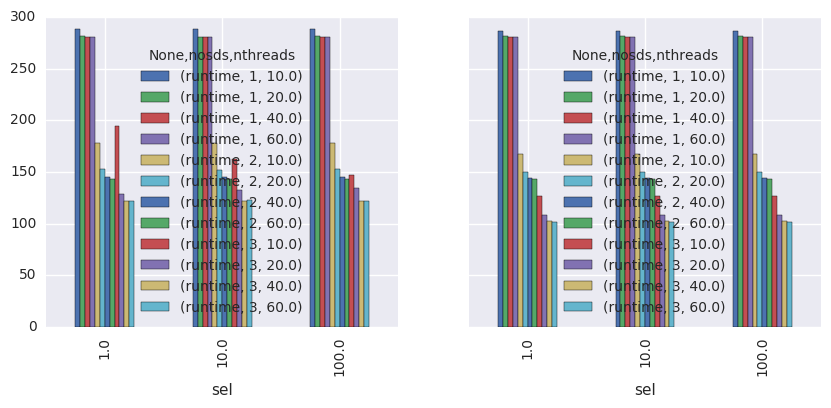

In [208]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(10,4))

df2 = df[(df["query"] == "a") & (df["cls"] == False)].set_index(['nosds', 'nthreads', 'sel'])
del df2['cls']
del df2['idx']
del df2['query']
df2.unstack([0,1]).plot.bar(ax=ax[0])

df2 = df[(df["query"] == "a") & (df["cls"] == True)].set_index(['nosds', 'nthreads', 'sel'])
del df2['cls']
del df2['idx']
del df2['query']
df2.unstack([0,1]).plot.bar(ax=ax[1])

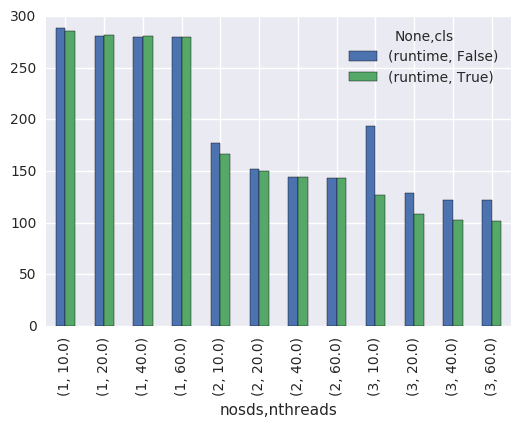

In [209]:
df2 = df[(df["query"] == "a") & (df["sel"] == 1.0)]
del df2['idx']
del df2['query']
del df2['sel']
df2 = df2.set_index(['cls', 'nosds', 'nthreads'])
df2.unstack(0).plot.bar()

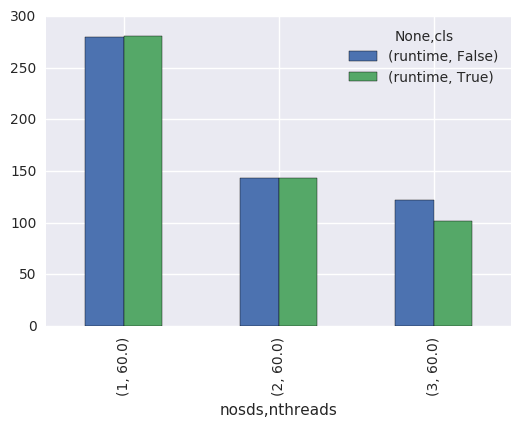

In [218]:
df2 = df[(df["query"] == "b") & (df["sel"] == 1.0) & (df["nthreads"] == 60.0)]
del df2['idx']
del df2['query']
del df2['sel']
df2 = df2.set_index(['cls', 'nosds', 'nthreads'])
df2.unstack(0).plot.bar()

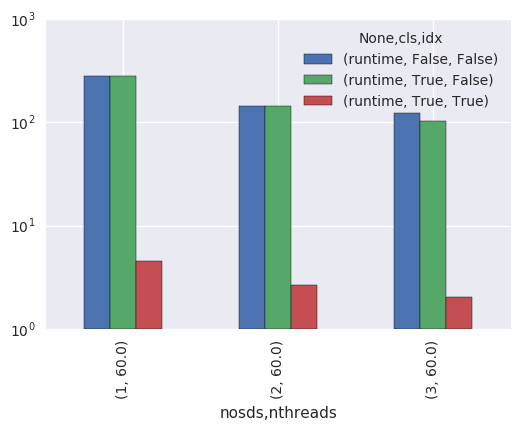

In [219]:
df2 = df[(df["query"] == "d") & (df["nthreads"]==60.0)]
del df2['query']
del df2['sel']
df2 = df2.set_index(['cls', 'idx', 'nosds', 'nthreads'])
df2.unstack([0, 1]).plot.bar(log=True)

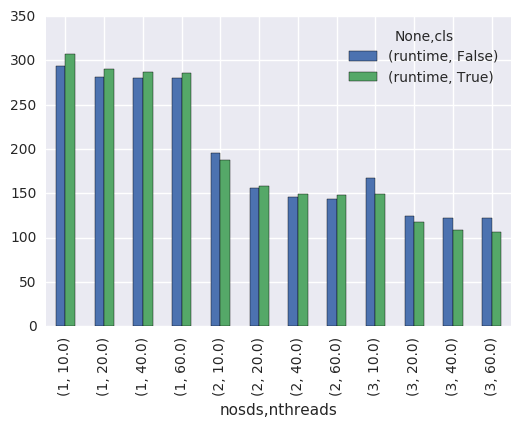

In [221]:
df2 = df[(df["query"] == "f") & (df["sel"] == 1.0)]
del df2['idx']
del df2['query']
del df2['sel']
df2 = df2.set_index(['cls', 'nosds', 'nthreads'])
df2.unstack(0).plot.bar()